In [1]:
%matplotlib inline
import numpy as np
# Print with smaller accurary to make comparisons easier
np.set_printoptions(precision=7, suppress=True)

import matplotlib.pyplot as plt
import scipy.sparse as sp

# Discretization
The discretization follows the first multi-grid worksheet completely.
We discretize
$$ \begin{array}{r c l}
-\cfrac{d^2 u}{d x^2}&=&f(x),~~~x\in(0,1),\\
u(0)=u(1) & = & 0.
\end{array}
$$
on a grid with $h=1/N$ and $N+1$ grid points.

Let's define a grid first.

In [2]:
class Grid(object):
    def __init__(self, num_points):
        # Num points does not include boundary!
        self.num_points = num_points
        self.spacing = 1.0/(num_points + 1)
        
    def get_nth_point(self, i):
        return self.spacing * (i + 1)
        

def make_grid(level):
    # Level is refinement
    # Consider interval [0,1]
    # Level one has one point at 1/2
    # Level two has points at 1/4, 1/2, 3/4
    num_points = 2**(level + 1) - 1
    return Grid(num_points)


grid = make_grid(level=2)
grid.get_nth_point(1)

0.25

We use a finite difference discretization and eliminate all rows corresponding to the Dirichlet boundary conditions.
For more details, see the worksheet.
The matrix then looks like:
$$A_{ij}:=\left\{\begin{array}{r c l}
-\frac{1}{h^2} & \hbox{if} & |i-j|=1,\\
\frac{2}{h^2} & \hbox{if} & i=j,\\
0 & \hbox{otherwise},\end{array}\right.
$$

In [3]:
def create_matrix(grid):
    n = grid.num_points
    h = grid.spacing
    
    def val(i,j):
        if i == j:
            return 2/h**2
        elif np.abs(i-j) == 1:
            return -1/h**2
        else:
            return 0.0
        
    return np.fromfunction(np.vectorize(val), (n, n), dtype=float)


discretization = create_matrix(grid)
discretization

array([[128., -64.,   0.,   0.,   0.,   0.,   0.],
       [-64., 128., -64.,   0.,   0.,   0.,   0.],
       [  0., -64., 128., -64.,   0.,   0.,   0.],
       [  0.,   0., -64., 128., -64.,   0.,   0.],
       [  0.,   0.,   0., -64., 128., -64.,   0.],
       [  0.,   0.,   0.,   0., -64., 128., -64.],
       [  0.,   0.,   0.,   0.,   0., -64., 128.]])

# Eigenvalues of the system matrix
As discussed in the worksheet, the eigenvectors of the matrix are
$u_i = sin(k\pi ih)$ with eigenvalue $\lambda=(4/h^2)\sin^2(k\pi h/2)$.
We also have that $c=k\pi, k\in\mathbb{Z}\setminus\{0\}$.

Let's verify our calculations numerically:

In [4]:
def analytical_eigenvalue(grid, k):
    h = grid.spacing
    c = k * np.pi
    return (4/h**2) * np.sin(c * grid.spacing * 0.5)**2

grid = make_grid(2)
discretization = create_matrix(grid)

numerical_eigenvals = np.linalg.eig(discretization)[0]

analytical_eigenvals = np.array([analytical_eigenvalue(grid,k) for k in range(1,grid.num_points+1)])
print("Numerical:", np.sort(numerical_eigenvals))
print("Analytical:", np.sort(analytical_eigenvals))
# They are in different order
diff = np.sort(numerical_eigenvals) - np.sort(analytical_eigenvals)
print("Difference:", diff)

Numerical: [  9.7434198  37.490332   79.0165207 128.        176.9834793 218.509668
 246.2565802]
Analytical: [  9.7434198  37.490332   79.0165207 128.        176.9834793 218.509668
 246.2565802]
Difference: [ 0.  0.  0. -0. -0. -0. -0.]


In [5]:
# The numerical ones are:
print(np.linalg.eig(discretization)[1])

[[ 0.1913417  0.3535534  0.4619398 -0.5       -0.1913417  0.3535534
   0.4619398]
 [-0.3535534 -0.5       -0.3535534  0.        -0.3535534  0.5
   0.3535534]
 [ 0.4619398  0.3535534 -0.1913417  0.5       -0.4619398  0.3535534
  -0.1913417]
 [-0.5       -0.         0.5       -0.        -0.5        0.
  -0.5      ]
 [ 0.4619398 -0.3535534 -0.1913417 -0.5       -0.4619398 -0.3535534
  -0.1913417]
 [-0.3535534  0.5       -0.3535534 -0.        -0.3535534 -0.5
   0.3535534]
 [ 0.1913417 -0.3535534  0.4619398  0.5       -0.1913417 -0.3535534
   0.4619398]]


In [6]:
def analytical_eigenvector(grid, k):
    n = grid.num_points
    h = grid.spacing
    c = k * np.pi
    
    eigenvec = np.array([np.sin(c * i * h) for i in range(1, n+1)])
    # Note: numpy always normalizes eigenvectors to unit length
    # So we also have to normalize the analytical ones
    return eigenvec/np.linalg.norm(eigenvec)

for k in range(0, grid.num_points):
    print(analytical_eigenvector(grid, k+1))

[0.1913417 0.3535534 0.4619398 0.5       0.4619398 0.3535534 0.1913417]
[ 0.3535534  0.5        0.3535534  0.        -0.3535534 -0.5
 -0.3535534]
[ 0.4619398  0.3535534 -0.1913417 -0.5       -0.1913417  0.3535534
  0.4619398]
[ 0.5  0.  -0.5 -0.   0.5  0.  -0.5]
[ 0.4619398 -0.3535534 -0.1913417  0.5       -0.1913417 -0.3535534
  0.4619398]
[ 0.3535534 -0.5        0.3535534  0.        -0.3535534  0.5
 -0.3535534]
[ 0.1913417 -0.3535534  0.4619398 -0.5        0.4619398 -0.3535534
  0.1913417]


# Eigenvalues of the Jacobi iteration matrices
We can also look at the eigenvalues of the (weighted) Jacobi iteration matrix.
It is defined as $$M=I-\omega\operatorname{diag}\left({A}\right)^{-1}A$$

The eigenvectors should be the same as for the discretization matrix $A$, the eigenvalues should be
$$1 - 2 \omega \left(\sin\left(\frac{k \pi h}{2}\right)\right)^2$$


In [7]:
"""
Returns a tuple of (iteration matrix, inverse diagonal part)
"""
def build_jacobi_matrices(grid, matrix, omega):
    n = grid.num_points
    h = grid.spacing
    A = np.zeros(matrix.shape)
    I = np.eye(grid.num_points,grid.num_points)
    inv_diag = I * (1.0/np.diag(matrix))
    return (I - omega * inv_diag @ matrix, inv_diag)
  
M, N = build_jacobi_matrices(grid, discretization, omega=2/3)
M

array([[0.3333333, 0.3333333, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.3333333, 0.3333333, 0.3333333, 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.3333333, 0.3333333, 0.3333333, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.3333333, 0.3333333, 0.3333333, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.3333333, 0.3333333, 0.3333333,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.3333333, 0.3333333,
        0.3333333],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.3333333,
        0.3333333]])

In [8]:
np.linalg.eig(M)

(array([ 0.949253 ,  0.8047379,  0.5884556,  0.3333333, -0.2825864,
        -0.1380712,  0.078211 ]),
 array([[ 0.1913417, -0.3535534,  0.4619398,  0.5      , -0.1913417,
         -0.3535534,  0.4619398],
        [ 0.3535534, -0.5      ,  0.3535534,  0.       ,  0.3535534,
          0.5      , -0.3535534],
        [ 0.4619398, -0.3535534, -0.1913417, -0.5      , -0.4619398,
         -0.3535534, -0.1913417],
        [ 0.5      , -0.       , -0.5      , -0.       ,  0.5      ,
         -0.       ,  0.5      ],
        [ 0.4619398,  0.3535534, -0.1913417,  0.5      , -0.4619398,
          0.3535534, -0.1913417],
        [ 0.3535534,  0.5      ,  0.3535534, -0.       ,  0.3535534,
         -0.5      , -0.3535534],
        [ 0.1913417,  0.3535534,  0.4619398, -0.5      , -0.1913417,
          0.3535534,  0.4619398]]))

In [9]:
def analytical_eigenvalue_jacobi(grid, k):
    h = grid.spacing
    c = k * np.pi
    return 1 - 2*2/3 * np.sin(c*h/2)**2#

analytical_eigenvals = np.array([analytical_eigenvalue_jacobi(grid,k) for k in range(1,grid.num_points+1)])
analytical_eigenvals

array([ 0.949253 ,  0.8047379,  0.5884556,  0.3333333,  0.078211 ,
       -0.1380712, -0.2825864])

In [10]:
for k in range(0, grid.num_points):
    print(analytical_eigenvector(grid, k+1))

[0.1913417 0.3535534 0.4619398 0.5       0.4619398 0.3535534 0.1913417]
[ 0.3535534  0.5        0.3535534  0.        -0.3535534 -0.5
 -0.3535534]
[ 0.4619398  0.3535534 -0.1913417 -0.5       -0.1913417  0.3535534
  0.4619398]
[ 0.5  0.  -0.5 -0.   0.5  0.  -0.5]
[ 0.4619398 -0.3535534 -0.1913417  0.5       -0.1913417 -0.3535534
  0.4619398]
[ 0.3535534 -0.5        0.3535534  0.        -0.3535534  0.5
 -0.3535534]
[ 0.1913417 -0.3535534  0.4619398 -0.5        0.4619398 -0.3535534
  0.1913417]


# A quick visualisation of the min/max problem
When solving the problem
 Show that $\omega=2/3$ is the best choice in the sense that it solves
 $$ \omega = \operatorname{argmin}_{\omega'}\max_{N/2 \leq k \leq N} |\lambda_k(\omega')| $$,
 where $\lambda_k$ is the $k$-th eigenvalue.
we end up with (see solution of ws2 for more details):
$$
\omega = \operatorname{argmin}_{\omega'}\max\left\{|\lambda_{N/2}(\omega')|, |\lambda_{N}(\omega')|\right\}
= \operatorname{argmin}_{\omega'}\max\left\{|1-\omega'|, |1-2\omega'|\right\}.
$$

The solution is very easy to see, once we plot the problem.
We are interested in the minimum of green curve:

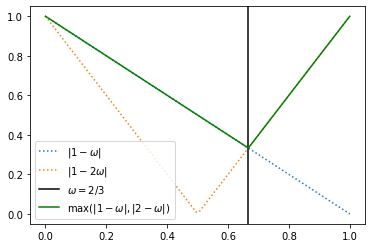

In [11]:
fig, ax = plt.subplots()
omegas = np.linspace(0, 1, 100)
opt_1 = np.abs(1 - omegas)
opt_2 = np.abs(1 - 2 * omegas)
ax.plot(omegas, opt_1, label="$| 1 - \omega | $", linestyle='dotted')
ax.plot(omegas, opt_2, label="$| 1 - 2\omega | $", linestyle='dotted')
ax.axvline(2/3, label="$\omega = 2/3$", c='black')

ax.plot(omegas, np.maximum(opt_1, opt_2),
        label="$\max(| 1 - \omega |, | 2 - \omega |)$",
        linestyle='solid', c='green')

ax.legend()